In [1648]:
%%capture
import scikits.samplerate
import sklearn
import os
import site
import numpy
import matplotlib

#"""

from mpl_toolkits.mplot3d import proj3d
def orthogonal_proj(zfront, zback):
    a = (zfront+zback)/(zfront-zback)
    b = -2*(zfront*zback)/(zfront-zback)
    return numpy.array([[1,0,0,0],
                        [0,1,0,0],
                        [0,0,a,b],
                        [0,0,-0.00001,1]])
proj3d.persp_transformation = orthogonal_proj

#"""

site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import logging
import theano.tensor as T
import lasagne
import logging
log = logging.getLogger()
log.setLevel("DEBUG")
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import matplotlib.lines as mlines
#import seaborn
#seaborn.set_style('whitegrid')
matplotlib.rcParams['figure.figsize'] = (16.0, 1.0)
matplotlib.rcParams['font.size'] = 7
from braindecode.scripts.print_results import ResultPrinter
import theano
import scipy.signal
import numpy as np


In [1649]:
%%javascript
function makeSVGDownloadable() {
    $('body').on('click', 'svg', function(){
        var svg = this.outerHTML;
        var b64 = btoa(svg); // or use btoa if supported
        var linkToSVG = $("<a href-lang='image/svg+xml' href='data:image/svg+xml;base64,\n" + b64 +
                          "'title='file.svg' target='blank'>Download</a>");
        $(this).after(linkToSVG);});
}
makeSVGDownloadable()

<IPython.core.display.Javascript object>

In [1650]:
import seaborn

seaborn.set_style('white')

In [2092]:
# see also http://openscholarship.wustl.edu/cgi/viewcontent.cgi?article=1150&context=eng_etds#page=14
from matplotlib.collections import PolyCollection
def cuboid_data(start_point, size):
    """
       Create a data array for cuboid plotting.


       ============= ================================================
       Argument      Description
       ============= ================================================
       start_point   Lower bottom left part of cuboid
       size          size of the cuboid, triple, (x_length,y_width,z_height)
       :type size: tuple, numpy.array, list
       :param size: size of the cuboid, triple, (x_length,y_width,z_height)
       :type center: tuple, numpy.array, list
       :param center: center of the cuboid, triple, (x,y,z)


      """


    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = start_point
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  # x coordinate of points in inside surface
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]    # y coordinate of points in inside surface
    z = [[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]                # z coordinate of points in inside surface
    return x, y, z

def orthogonal_proj(zfront, zback):
    a = (zfront+zback)/(zfront-zback)
    b = -2*(zfront*zback)/(zfront-zback)
    return np.array([[1,0,0,0],
                        [-0.86602686,1,0,0],
                        [0,0,a,b],
                        [0,0,-1e-5,zback]])

proj3d.persp_transformation = orthogonal_proj


def add_rect(ax, xz, length, height, ys=0,**polyargs):
    poly = PolyCollection(np.array([[[xz[0],xz[1]],
                                     [xz[0]+length,xz[1]],
                                     [xz[0]+length,xz[1]+height],
                                     [xz[0],xz[1]+height]]]),
                         **polyargs)
    ax.add_collection3d(poly, zs=ys, zdir='y')
    return poly

def plot_featuremap(xyz, length, width, height, l_str=None, w_str=None, h_str=None, **annotate_args):
    return plot_cuboid(xyz, length, width, height, featuremap_color,
                      l_str=l_str, w_str=w_str, h_str=h_str, text_color='black',
                      **annotate_args)
    
def plot_filters(xyz, length, width, height, l_str=None, w_str=None, h_str=None, **annotate_args):
    return plot_cuboid(xyz, length, width, height, filter_color,
                        l_str=l_str, w_str=w_str, h_str=h_str, text_color=text_filter_color,
                       topleft_annotate=True,
                      **annotate_args)
    

def plot_cuboid(xyz, length, width, height, color, l_str=None, w_str=None, h_str=None,
                text_color='black', topleft_annotate=False, **annotate_args):
    X, Y, Z = cuboid_data(xyz, (length, width, height))
    cuboid = ax.plot_surface(X, Y, Z, color=color,
                    rstride=1, cstride=1, shade=False,
                    edgecolors='black')
    if l_str is not None:
        assert (w_str is not None) and (h_str is not None)
        if topleft_annotate: 
            annotate_cub_sizes_topleft(xyz,length,width,height,
                           l_str, w_str, h_str,
                           color=text_color,
                           **annotate_args)
        else:
             annotate_cub_sizes(xyz,length,width,height,
                           l_str, w_str, h_str,
                           color=text_color,
                           **annotate_args)
    return cuboid

def annotate_cub_sizes(xyz, length, width, height, 
                       xtext, ytext, ztext,fontsize=12, boxpad=-0.5,boxalpha=1,**text_args):
    ax.text3D(*(np.array(xyz) + [length / 16.0, 0, 0]), s=xtext, 
          transform=offset_copy(ax.transData, fig, x=0.0, y=-0.05),
              va='top', fontsize=fontsize, backgroundcolor='white',
              bbox=dict(pad=boxpad, color='white', alpha=boxalpha), zorder= 10,
              **text_args)
    ax.text3D(*(np.array(xyz) + [0, width / 2.0,0]),s=ytext, 
              transform=offset_copy(ax.transData,fig,x=-0.05,y=-0.05),
             ha='right', va='center', fontsize=fontsize, backgroundcolor='white',
              bbox=dict(pad=boxpad, color='white', alpha=boxalpha), zorder= 10,
              **text_args)
    ax.text3D(*(np.array(xyz) + [0, width, height/2.0]), s=ztext, 
              transform=offset_copy(ax.transData, fig, x=-0.05,y=0),
              ha='right', va='center', fontsize=fontsize, backgroundcolor='white',
              bbox=dict(pad=boxpad, color='white', alpha=boxalpha), zorder= 10,
              **text_args)
    
def annotate_cub_sizes_topleft(xyz, length, width, height, 
                       xtext, ytext, ztext,fontsize=12, boxpad=-0.5,boxalpha=1,**text_args):
    top_left_xyz = np.array(xyz) + np.array([length,width,height])
    ax.text3D(*(top_left_xyz - [length/2.0, 0, 0]), s=xtext, 
          transform=offset_copy(ax.transData, fig, x=0.0, y=+0.025),
              ha='center',
              va='bottom', fontsize=fontsize, backgroundcolor='white',
              bbox=dict(pad=boxpad, color='white', alpha=boxalpha), zorder= 10,
              **text_args)
    ax.text3D(*(top_left_xyz - [0, width / 2.0,0]),s=ytext, 
              transform=offset_copy(ax.transData,fig,x=+0.05,y=+0.05),
             ha='left', va='center', fontsize=fontsize, backgroundcolor='white',
              bbox=dict(pad=boxpad, color='white', alpha=boxalpha), zorder= 10,
              **text_args)
    ax.text3D(*(top_left_xyz - [0, width, height/2.0]), s=ztext, 
              transform=offset_copy(ax.transData, fig, x=+0.05,y=0),
              ha='left', va='center', fontsize=fontsize, backgroundcolor='white',
              bbox=dict(pad=boxpad, color='white', alpha=boxalpha), zorder= 10,
              **text_args)

def draw_vertical_connector(z_start,z_end):
    ax.plot3D([0,0], [0,0], zs=[z_start,z_end], linestyle='dotted',
         linewidth=1., color='black')

In [2025]:
from braindecode.datasets.loaders import BBCIDataset

In [2026]:
cnt = BBCIDataset('data/BBCI-only-last-runs/BhNoMoSc1S001R13_ds10_1-2BBCI.mat', load_sensor_names=['C3', 'C4',
                                                                                                  'CP4']).load()

cnt = resample_cnt(cnt, 250,)
cnt = exponential_standardize_cnt(cnt)

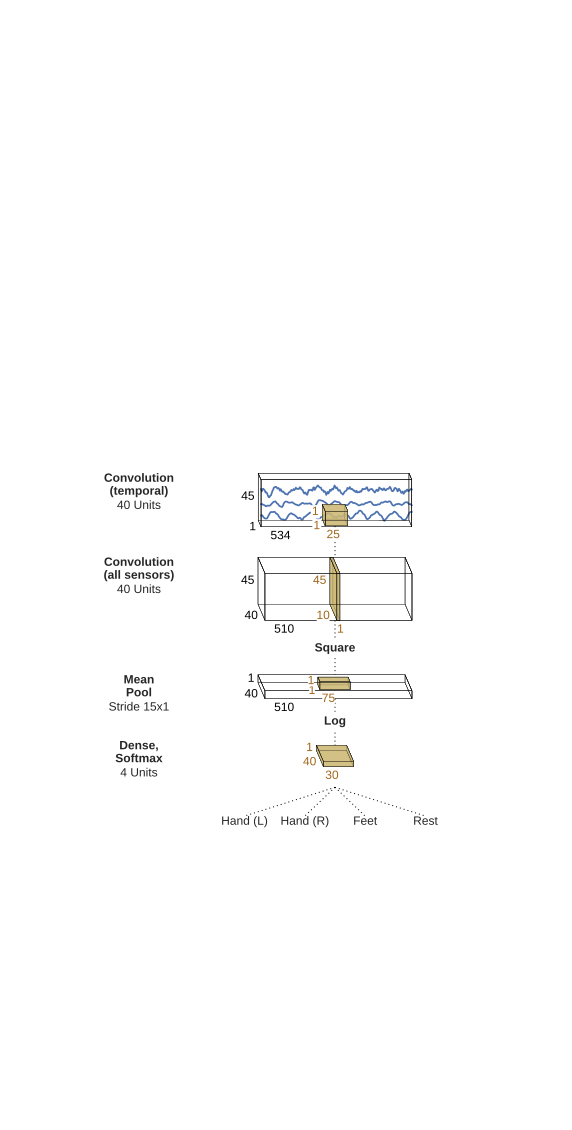

In [2032]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'png' 
fig = plt.figure(figsize=(12,20))


%config InlineBackend.figure_format = 'svg' 
fig = plt.figure(figsize=(10,20))
ax = fig.gca(projection='3d')

ax.set_xlim3d(-100, 900)
ax.set_ylim3d(-100, 800)
ax.set_zlim3d(-1000, 0)
ax.view_init(30,210)

#plt.tight_layout()
plt.axis('off')
no_color = (1,1,1,0)
black = (0,0,0,1)

featuremap_color = (1,1,1,0.0)
brown = seaborn.color_palette("BrBG")[0]#(132/255.0, 98/255.0, 98/255.0)
filter_color = seaborn.color_palette()[4] + (0.5,)#brown + (0.5,) #seaborn.color_palette()[4] + (0.7,)
activation_color = brown
text_filter_color = brown

# rough width to height conversion
width_factor = 1.3 / 2.0


length_f0, width_f0, height_f0 = 1000, 10, 90
feature_0_xyz = -length_f0/2.0, -width_f0/2.0, 0
feature_0 = plot_featuremap(feature_0_xyz, length_f0, width_f0, height_f0,
                           "534", "1", "45")

for i_chan, z_offset in enumerate((20,45,70)):
    ax.plot3D(np.linspace(feature_0_xyz[0],
                          feature_0_xyz[0]+length_f0,200), 
                          [feature_0_xyz[1]] * 200,
                          zs=9/2.0*cnt.data[12035:12235, i_chan] + z_offset,
                         color=seaborn.color_palette()[0])

    
filters_0_xyz = (-75, feature_0_xyz[1], 2)
filters_0 = plot_filters(filters_0_xyz, 150, width_f0, 28,
                         "25", "1", "1", boxpad=1, boxalpha=1)

# first featuremap
length_f1, width_f1, height_f1 = 975, 40 * 0.6, 90
feature_1_xyz = -length_f1/2.0, -width_f1/2.0, -170
feature_1 = plot_featuremap(feature_1_xyz, length_f1,width_f1, height_f1, '510', '40', ' 45')
filters_1_xyz = (feature_1_xyz[0] + (length_f1)/2 -10,
              feature_1_xyz[1], feature_1_xyz[2]) 
filters_1 = plot_filters(filters_1_xyz, 20, width_f1, height_f1, '1','10','45')

# square
square_z = feature_1_xyz[2] - 75
ax.text3D(0,0,square_z, 'Square', ha='center', fontsize=12, weight='bold',
         backgroundcolor='white')

#second featuremap
length_f2, width_f2, height_f2 = 975, 40 * 0.6, 15
feature_2_xyz = -length_f2/2.0, -width_f2/2.0, square_z-75
plot_featuremap(feature_2_xyz, length_f2,width_f2, height_f2,
                  '510', '40', '1')
pool_len = 200
filter_2_xyz = (-pool_len / 2.0, 0, feature_2_xyz[2]+2)
plot_filters(filter_2_xyz, pool_len, 7, height_f2,
                  '75', '1', '1',)
# log
log_z = feature_2_xyz[2] - 65
ax.text3D(0,0,log_z, 'Log', ha='center', fontsize=12, weight='bold',
         backgroundcolor='white')

# final softmax
length_soft, width_soft, height_soft = 100 * 2, 20 * 2 * 0.6, 10
feature_soft_xyz = -length_soft/2.0, -width_soft/2.0, log_z-65
plot_filters(feature_soft_xyz,
            length_soft, width_soft, height_soft, '30', '40', '1')
# connectors
draw_vertical_connector(-5,feature_1_xyz[2]+height_f1+width_f1*width_factor)
draw_vertical_connector(feature_1_xyz[2]-width_factor*width_f1, square_z)
draw_vertical_connector(square_z-5,feature_2_xyz[2]+height_f2+width_f2*width_factor)
draw_vertical_connector(feature_2_xyz[2]-width_f2*width_factor,log_z)
draw_vertical_connector(log_z, feature_soft_xyz[2]+height_soft+width_soft*width_factor)


# final outs 

text_z = feature_soft_xyz[2] - 110

text_dist = 400

ax.text3D(-text_dist - text_dist / 2.0, 0, text_z, zdir=(0,0,0),s='Hand (L)', fontsize=12,va='top', ha='center')
ax.text3D(-text_dist / 2.0, 0, text_z, zdir=(0,0,0),s='Hand (R)', fontsize=12,va='top', ha='center')
ax.text3D(text_dist / 2.0, 0, text_z, zdir=(0,0,0),s='Feet', fontsize=12,va='top', ha='center')
ax.text3D(text_dist + text_dist / 2.0, 0, text_z, zdir=(0,0,0),s='Rest', fontsize=12,va='top', ha='center')

# connector
ax.plot3D([0, -text_dist - text_dist / 2.0], ys=[0,0], zs=[feature_soft_xyz[2] - 55, text_z], linestyle='dotted',
         linewidth=1., color='black')
ax.plot3D([0,-text_dist / 2.0,], ys=[0,0], zs=[feature_soft_xyz[2] - 55, text_z], linestyle='dotted',
         linewidth=1., color='black')
ax.plot3D([0,text_dist / 2.0], ys=[0,0], zs=[feature_soft_xyz[2] - 55, text_z], linestyle='dotted',
         linewidth=1., color='black')
ax.plot3D([0,text_dist + text_dist / 2.0], ys=[0,0], zs=[feature_soft_xyz[2] - 55, text_z], linestyle='dotted',
         linewidth=1., color='black')
fig.savefig('to-delete.png')


explain_fontsize=12
text_x_headers = -1300 
ax.text3D(text_x_headers, 0, feature_0_xyz[2] + height_f0 * 1 + width_f0 * width_factor,
          'Convolution\n(temporal)', 
           weight='bold', ha='center',
         fontsize=explain_fontsize,  va='top',)
ax.text3D(text_x_headers, 0, feature_1_xyz[2] + height_f1 * 1 + width_f1 * width_factor,
          'Convolution\n(all sensors)', ha='center',
         weight='bold', fontsize=explain_fontsize,  va='top')
ax.text3D(text_x_headers, 0, feature_2_xyz[2] + height_f2 * 1 + width_f2 * width_factor,
          'Mean\nPool\n', ha='center',
         weight='bold', fontsize=explain_fontsize,  va='top')
ax.text3D(text_x_headers, 0, feature_soft_xyz[2] + height_f3 * 1 + width_f3 * width_factor,
          'Dense,\nSoftmax', ha='center',
         weight='bold', fontsize=explain_fontsize,  va='top')

text_x_filt = text_x_headers 
offset_z = -52
ax.text3D(text_x_filt, 0, feature_0_xyz[2] + height_f0 * 1 + width_f0 * width_factor+offset_z,'40 Units', ha='center',
         fontsize=explain_fontsize,  va='top')
ax.text3D(text_x_filt, 0, feature_1_xyz[2] + height_f1 * 1 + width_f1 * width_factor+offset_z,'40 Units', ha='center',
         fontsize=explain_fontsize,  va='top')
ax.text3D(text_x_filt, 0, feature_2_xyz[2] + height_f2 * 1 + width_f2 * width_factor+offset_z, 'Stride 15x1', ha='center',
         fontsize=explain_fontsize,  va='top')
ax.text3D(text_x_filt, 0, feature_soft_xyz[2] + height_f3 * 1 + width_f3 * width_factor+offset_z, '4 Units', ha='center',
         fontsize=explain_fontsize,  va='top')



In [2093]:
def elu(x):
    return (x >= 0) * x + (x < 0) * (np.exp(x) - 1)

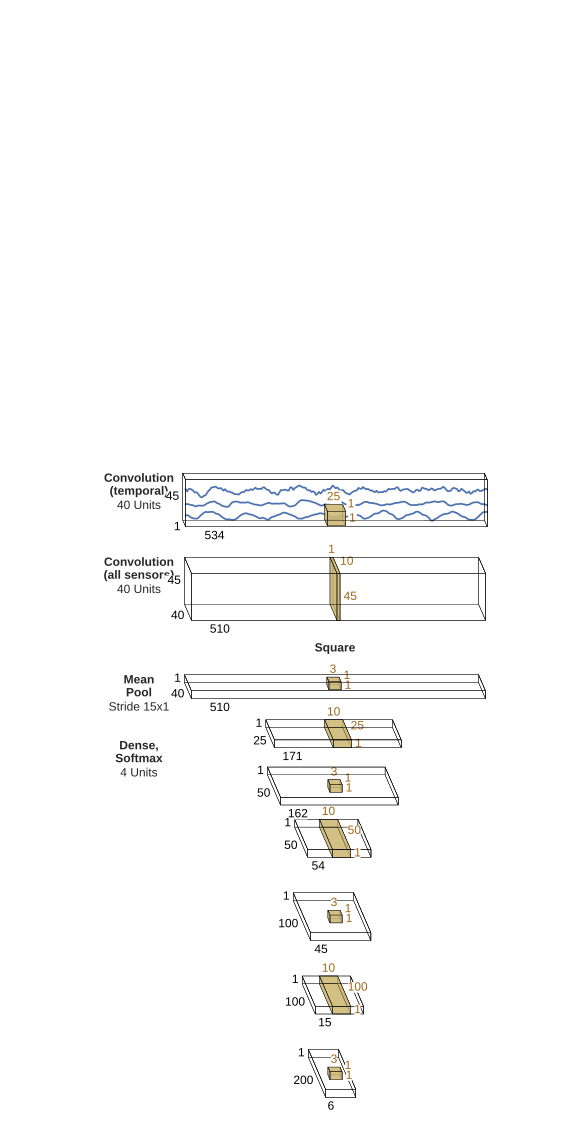

In [2094]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'png' 
fig = plt.figure(figsize=(12,20))


%config InlineBackend.figure_format = 'svg' 
fig = plt.figure(figsize=(10,20))
ax = fig.gca(projection='3d')

ax.set_xlim3d(-100, 900)
ax.set_ylim3d(-100, 800)
ax.set_zlim3d(-1000, 0)
ax.view_init(30,210)

#plt.tight_layout()
plt.axis('off')
no_color = (1,1,1,0)
black = (0,0,0,1)

featuremap_color = (1,1,1,0.0)
brown = seaborn.color_palette("BrBG")[0]#(132/255.0, 98/255.0, 98/255.0)
filter_color = seaborn.color_palette()[4] + (0.5,)#brown + (0.5,) #seaborn.color_palette()[4] + (0.7,)
activation_color = brown
text_filter_color = brown

filter_len = 120
pool_len = 80

# rough width to height conversion
width_factor = 1.3 / 2.0


length_f0, width_f0, height_f0 = 2000, 10, 90
feature_0_xyz = -length_f0/2.0, -width_f0/2.0, 0
feature_0 = plot_featuremap(feature_0_xyz, length_f0, width_f0, height_f0,
                           "534", "1", "45")

for i_chan, z_offset in enumerate((20,45,70)):
    ax.plot3D(np.linspace(feature_0_xyz[0],
                          feature_0_xyz[0]+length_f0,200), 
                          [feature_0_xyz[1]] * 200,
                          zs=9/2.0*cnt.data[12035:12235, i_chan] + z_offset,
                         color=seaborn.color_palette()[0])

    
filters_0_xyz = (-filter_len/2.0, feature_0_xyz[1], 2)
filters_0 = plot_filters(filters_0_xyz, filter_len, width_f0, 28,
                         "25", "1", "1", boxpad=1, boxalpha=1)

# first featuremap
length_f1, width_f1, height_f1 = 1950, 40 * 0.6, 90
feature_1_xyz = -length_f1/2.0, -width_f1/2.0, -170
feature_1 = plot_featuremap(feature_1_xyz, length_f1,width_f1, height_f1, '510', '40', ' 45')
filters_1_xyz = (feature_1_xyz[0] + (length_f1)/2 -10,
              feature_1_xyz[1], feature_1_xyz[2]) 
filters_1 = plot_filters(filters_1_xyz, 20, width_f1, height_f1, '1','10','45')

# square
square_z = feature_1_xyz[2] - 75
ax.text3D(0,0,square_z, 'Square', ha='center', fontsize=12, weight='bold',
         backgroundcolor='white')

#second featuremap
length_f2, width_f2, height_f2 = 1950, 40 * 0.6, 15
feature_2_xyz = -length_f2/2.0, -width_f2/2.0, square_z-75
plot_featuremap(feature_2_xyz, length_f2,width_f2, height_f2,
                  '510', '40', '1')
filter_2_xyz = (-pool_len / 2.0, 0, feature_2_xyz[2]+2)
plot_filters(filter_2_xyz, pool_len, 7, height_f2,
                  '3', '1', '1',)
class ConvPoolBlock(object):
    def __init__(self, in_conv_length, in_conv_width, in_conv_height, in_conv_z,
                   filter_len, filt_width, filt_height, 
                   in_pool_len, in_pool_width, in_pool_conv_z_diff,
                   pool_len, pool_width, pool_height,
                   in_conv_len_str, in_conv_width_str, in_conv_height_str,
                   filt_len_str, filt_width_str, filt_height_str,
                   in_pool_len_str, in_pool_width_str, in_pool_height_str,
                   pool_len_str, pool_width_str, pool_height_str):
        self.__dict__.update(locals())
        del self.self
        self.in_conv_xyz = [-self.in_conv_length/2.0 - self.in_conv_width * width_factor / 2.0, 
                            -self.in_conv_width/2.0, 
                            self.in_conv_z]
        self.filt_xyz = [-self.filter_len / 2.0, -self.filt_width / 2.0 , 
            self.in_conv_z + self.in_conv_height / 2.0 - self.filt_height / 2.0]
        self.in_pool_xyz = [-self.in_pool_len/2.0 - self.in_pool_width * width_factor /2.0, 
                            -self.in_pool_width/2.0, 
                            self.in_conv_z - self.in_pool_conv_z_diff]
        self.pool_xyz = [-self.pool_len / 2.0, -self.pool_width / 2.0, 
            self.in_pool_xyz[2] + self.in_conv_height / 2.0 - self.pool_height / 2.0]
        
    
    def draw(self):
        plot_featuremap(self.in_conv_xyz, self.in_conv_length, self.in_conv_width, self.in_conv_height,
                      self.in_conv_len_str, self.in_conv_width_str, self.in_conv_height_str)
        plot_filters(self.filt_xyz, self.filter_len, self.filt_width, self.filt_height,
                      self.filt_len_str, self.filt_width_str, self.filt_height_str,)
        plot_featuremap(self.in_pool_xyz, self.in_pool_len, self.in_pool_width, self.in_conv_height,
                      self.in_pool_len_str, self.in_pool_width_str, self.in_pool_height_str)
        plot_filters(self.pool_xyz, self.pool_len, self.pool_width, self.pool_height,
                      self.pool_len_str, self.pool_width_str, self.pool_height_str)
        
        return self.in_conv_xyz, self.in_pool_xyz

length_f3, width_f3, height_f3 = 840, 50 * 0.6, 15
conv_3_z = feature_2_xyz[2]-90
width_filt_3, height_filt_3 = width_f3, height_f3
pool_conv_z_diff = 100
in_pool_length_3, in_pool_width_3 = 780, 75 * 0.6
pool_width_3, pool_height_3 = 7, height_f3

block = ConvPoolBlock(
    length_f3, width_f3, height_f3,
    conv_3_z,
    filter_len,width_filt_3, height_filt_3, 
    in_pool_length_3, in_pool_width_3,
    pool_conv_z_diff,
    pool_len, pool_width_3, pool_height_3,
    '171', '25', '1', 
    '10','25','1',
    '162','50','1',
    '3','1','1')
block.filt_xyz[0] += 20
conv_3_xyz, pool_3_xyz = block.draw()

length, width, height = 420, 75 * 0.6, 15
conv_z = pool_3_xyz[2] - 100
width_filt, height_filt = width, height
pool_conv_z_diff = 150
in_pool_length, in_pool_width = 400, 100 * 0.6
pool_width, pool_height = 7, height

block = ConvPoolBlock(
    length, width, height, 
    conv_z,
    filter_len,width_filt, height_filt, 
    in_pool_length, in_pool_width,
    pool_conv_z_diff,
    pool_len, pool_width, pool_height,
    '54', '50', '1', 
    '10','50','1',
    '45','100','1',
    '3','1','1')
conv_4_xyz, pool_4_xyz = block.draw()

length, width, height = 320, 75 * 0.6, 15
conv_z = pool_4_xyz[2] - 150
width_filt, height_filt = width, height
pool_conv_z_diff = 150
in_pool_length, in_pool_width = 200, 100 * 0.6
pool_width, pool_height = 7, height

block = ConvPoolBlock(
    length, width, height, 
    conv_z,
    filter_len,width_filt, height_filt, 
    in_pool_length, in_pool_width,
    pool_conv_z_diff,
    pool_len, pool_width, pool_height,
    '15', '100', '1', 
    '10','100','1',
    '6','200','1',
    '3','1','1')
conv_5_xyz, pool_5_xyz = block.draw()

# final softmax
"""length_soft, width_soft, height_soft = 100 * 2, 20 * 2 * 0.6, 10
feature_soft_xyz = -length_soft/2.0, -width_soft/2.0, log_z-65
plot_filters(feature_soft_xyz,
            length_soft, width_soft, height_soft, '30', '40', '1')


# connectors
draw_vertical_connector(-5,feature_1_xyz[2]+height_f1+width_f1*width_factor)
draw_vertical_connector(feature_1_xyz[2]-width_factor*width_f1, square_z)
draw_vertical_connector(square_z-5,feature_2_xyz[2]+height_f2+width_f2*width_factor)
#draw_vertical_connector(feature_2_xyz[2]-width_f2*width_factor,log_z)
#draw_vertical_connector(log_z, feature_soft_xyz[2]+height_soft+width_soft*width_factor)


# final outs 

text_z = feature_soft_xyz[2] - 110

text_dist = 400

ax.text3D(-text_dist - text_dist / 2.0, 0, text_z, zdir=(0,0,0),s='Hand (L)', fontsize=12,va='top', ha='center')
ax.text3D(-text_dist / 2.0, 0, text_z, zdir=(0,0,0),s='Hand (R)', fontsize=12,va='top', ha='center')
ax.text3D(text_dist / 2.0, 0, text_z, zdir=(0,0,0),s='Feet', fontsize=12,va='top', ha='center')
ax.text3D(text_dist + text_dist / 2.0, 0, text_z, zdir=(0,0,0),s='Rest', fontsize=12,va='top', ha='center')

# connector
ax.plot3D([0, -text_dist - text_dist / 2.0], ys=[0,0], zs=[feature_soft_xyz[2] - 55, text_z], linestyle='dotted',
         linewidth=1., color='black')
ax.plot3D([0,-text_dist / 2.0,], ys=[0,0], zs=[feature_soft_xyz[2] - 55, text_z], linestyle='dotted',
         linewidth=1., color='black')
ax.plot3D([0,text_dist / 2.0], ys=[0,0], zs=[feature_soft_xyz[2] - 55, text_z], linestyle='dotted',
         linewidth=1., color='black')
ax.plot3D([0,text_dist + text_dist / 2.0], ys=[0,0], zs=[feature_soft_xyz[2] - 55, text_z], linestyle='dotted',
         linewidth=1., color='black')
fig.savefig('to-delete.png')
"""

explain_fontsize=12
text_x_headers = -1300 
ax.text3D(text_x_headers, 0, feature_0_xyz[2] + height_f0 * 1 + width_f0 * width_factor,
          'Convolution\n(temporal)', 
           weight='bold', ha='center',
         fontsize=explain_fontsize,  va='top',)
ax.text3D(text_x_headers, 0, feature_1_xyz[2] + height_f1 * 1 + width_f1 * width_factor,
          'Convolution\n(all sensors)', ha='center',
         weight='bold', fontsize=explain_fontsize,  va='top')
ax.text3D(text_x_headers, 0, feature_2_xyz[2] + height_f2 * 1 + width_f2 * width_factor,
          'Mean\nPool\n', ha='center',
         weight='bold', fontsize=explain_fontsize,  va='top')
ax.text3D(text_x_headers, 0, feature_soft_xyz[2] + height_f3 * 1 + width_f3 * width_factor,
          'Dense,\nSoftmax', ha='center',
         weight='bold', fontsize=explain_fontsize,  va='top')

text_x_filt = text_x_headers 
offset_z = -52
ax.text3D(text_x_filt, 0, feature_0_xyz[2] + height_f0 * 1 + width_f0 * width_factor+offset_z,'40 Units', ha='center',
         fontsize=explain_fontsize,  va='top')
ax.text3D(text_x_filt, 0, feature_1_xyz[2] + height_f1 * 1 + width_f1 * width_factor+offset_z,'40 Units', ha='center',
         fontsize=explain_fontsize,  va='top')
ax.text3D(text_x_filt, 0, feature_2_xyz[2] + height_f2 * 1 + width_f2 * width_factor+offset_z, 'Stride 15x1', ha='center',
         fontsize=explain_fontsize,  va='top')
ax.text3D(text_x_filt, 0, feature_soft_xyz[2] + height_f3 * 1 + width_f3 * width_factor+offset_z, '4 Units', ha='center',
         fontsize=explain_fontsize,  va='top')



In [1907]:
from braindecode.experiments.load import load_exp_and_model
from braindecode.veganlasagne.layers import transform_to_normal_net

In [1908]:
exp, model =load_exp_and_model('data/models/paper/ours/cnt/shallow/2089')
print_layers(transform_to_normal_net(model))

INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 467
INFO:braindecode.experiments.experiment:Input window length is 534
INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 467
INFO:braindecode.experiments.experiment:Input window length is 534


 0 InputLayer                                                         [None, 45, 534, 1]
 1 DimshuffleLayer                                                    (None, 1, 534, 45)
 2 Conv2DLayer              25x1                                      (None, 40, 510, 45)
 3 Conv2DAllColsLayer       1x45                      Elemwise{sqr,no_inplace} (None, 40, 510, 1)
 4 Pool2DLayer              75x1 ::15 ::1             average_exc_pad (None, 40, 30, 1)
 5 NonlinearityLayer                                  safe_log       
 6 DropoutLayer                                                      
 7 Conv2DLayer              30x1                                      (None, 4, 1, 1)
 8 FlattenLayer                                                       (None, 4)
 9 NonlinearityLayer                                  safe_softmax   



In [1804]:
from braindecode.veganlasagne.layer_util import  print_layers

In [1920]:
exp, model =load_exp_and_model('data/models/paper/ours/cnt/deep4/4201')
print_layers(transform_to_normal_net(model))

INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 479
INFO:braindecode.experiments.experiment:Input window length is 522
INFO:braindecode.experiments.experiment:Setting n_sample preds automatically to 479
INFO:braindecode.experiments.experiment:Input window length is 522


 0 InputLayer                                                         [None, 45, 522, 1]
 1 DimshuffleLayer                                                    (None, 1, 522, 45)
 2 DropoutLayer                                                      
 3 Conv2DLayer              10x1                                      (None, 25, 513, 45)
 4 Conv2DAllColsLayer       1x45                                      (None, 25, 513, 1)
 5 BatchNormLayer                                     elu            
 6 Pool2DLayer              3x1 ::3 ::1               max             (None, 25, 171, 1)
 7 NonlinearityLayer                                                 
 8 DropoutLayer                                                      
 9 Conv2DLayer              10x1                                      (None, 50, 162, 1)
10 BatchNormLayer                                     elu            
11 Pool2DLayer              3x1 ::3 ::1               max             (None, 50, 54, 1)
12 NonlinearityLayer       

In [ ]:
# somehow this plots correctly eventhough coordinates are very smal
# I don't understand meaning of text_bbox.x0's value
def text_data_bbox(text, renderer, ax):
    bbox = text.get_window_extent(renderer)
    transf = ax.transData.inverted()
    bb_datacoords = bbox.transformed(transf)
    return bb_datacoords

text_bbox = text_data_bbox(text_1, fig.canvas.renderer, ax)
artist = ax.add_artist(plt.Rectangle([text_bbox.x0, text_bbox.y0],
                            text_bbox.width * 1.2, text_bbox.height,
                           transform=ax.transData),
             )

## Old stuff, other projections etc

#### Loading svg into cell to copy it

In [ ]:
fig.savefig('temp-to-delete.svg', format='svg')

In [ ]:
#%load temp-to-delete.svg

### Fixing axes code

In [402]:
# fixing axes
from StringIO import StringIO


from xml.etree import ElementTree
string_file = StringIO()
fig.savefig(string_file, format='svg')
string_file.seek(0)
#print string_file.read()
#string_file.seek(0)
e = ElementTree.parse(string_file)

e = e.getroot()

for element in e.iter():
    if element.attrib.get('id', None) == 'line2d_1':
        axis_line = element
        print axis_line.getchildren()[0].attrib['d']

M 591.13351 381.959532  L 434.040598 381.959532  


/home/schirrmr/motor-imagery/ipython-notebooks-metagpu/venv/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


### Other projections code

M 194.337 285.101884  L 520.848718 285.101884  


/home/schirrmr/motor-imagery/ipython-notebooks-metagpu/venv/lib/python2.7/site-packages/ipykernel/__main__.py:98: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


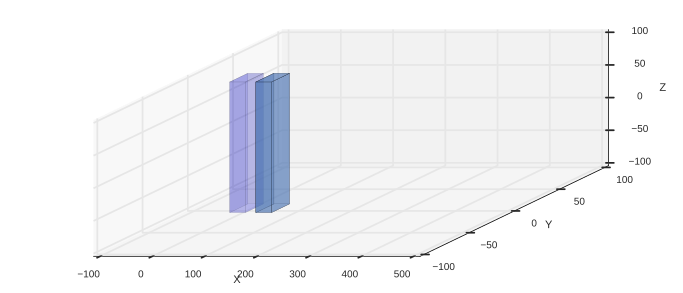

In [2019]:
def cuboid_data(center, size):
    """
       Create a data array for cuboid plotting.


       ============= ================================================
       Argument      Description
       ============= ================================================
       center        center of the cuboid, triple
       size          size of the cuboid, triple, (x_length,y_width,z_height)
       :type size: tuple, numpy.array, list
       :param size: size of the cuboid, triple, (x_length,y_width,z_height)
       :type center: tuple, numpy.array, list
       :param center: center of the cuboid, triple, (x,y,z)


      """


    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  # x coordinate of points in inside surface
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]    # y coordinate of points in inside surface
    z = [[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]                # z coordinate of points in inside surface
    return x, y, z


import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
center = [0, 0, 0]
length = 15 * 2
width = 10 * 2
height = 100 * 2
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,5))
ax = fig.gca(projection='3d')
X, Y, Z = cuboid_data(center, (length, width, height))
ax.plot_surface(X, Y, Z, color='b', rstride=1, cstride=1, alpha=0.1)
ax.set_xlabel('X')
ax.set_xlim(-100, 100)
ax.set_ylabel('Y')
ax.set_ylim(-100, 100)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)
ax.view_init(elev=20, azim=20)
#plt.axis('off')


center = [50, 0, 0]
length = 15 * 2
width = 10 * 2
height = 100 * 2


X, Y, Z = cuboid_data(center, (length, width, height))
ax.plot_surface(X, Y, Z, color=seaborn.color_palette()[0],
                rstride=1, cstride=1, shade=False, alpha=0.3)
ax.set_xlim3d(-100, 500)

# fixing axes
from StringIO import StringIO


%config InlineBackend.figure_format = 'svg' 
def orthogonal_proj(zfront, zback):
    a = (zfront+zback)/(zfront-zback)
    b = -2*(zfront*zback)/(zfront-zback)
    return np.array([[1,0,0,0],
                        [0.28867551,1,0,0],
                        [0,0,a,b],
                        [0,0,-1e-5,zback]])
proj3d.persp_transformation = orthogonal_proj
ax.view_init(30,300)
from xml.etree import ElementTree
string_file = StringIO()
fig.savefig(string_file, format='svg')
string_file.seek(0)
e = ElementTree.parse(string_file)

e = e.getroot()

for element in e.iter():
    if element.attrib.get('id', None) == 'line2d_1':
        axis_line = element
        print axis_line.getchildren()[0].attrib['d']
None